# CNN model za binarnu klasifikaciju
U nastavku se nalazi projekat koji za cilj ima kreiranje konvolutivne neuralne mreže u cilju binarne klasifikacije. 
Za ulazni dataset se koristi [dataset sa Kaggle repozitorijuma](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) Chest X-Ray Images (Pneumonia), koji sadrži fotografije rendgena grudnog koša koji su podeljeni na primere zdravih pacijenata i pacijenata sa upalom pluća, gde je cilj dobiti model koji će na novoj instanci predvideti da li je nova ulazna fotografija rendgena grudnog koša zdravog pacijenta ili sa pneumonijom. 

### Učitavanje potrebnih biblioteka, postavljanje random seed-a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import random
import shutil
import os
from sklearn import metrics
import seaborn as sns
from sklearn.utils import class_weight
tf.random.set_seed(22)
np.random.seed(22)
random.seed(22)

### Analiza ulaznog skupa
Ulazni skup podataka podeljen u tri direktorijuma - train, validation i test, a svaki od njih ima i pod-direktorijum PNEUMONIA i NORMAL što su target varijable u ovom slučaju. Za početak potrebno je analizirati ulazni skup. 

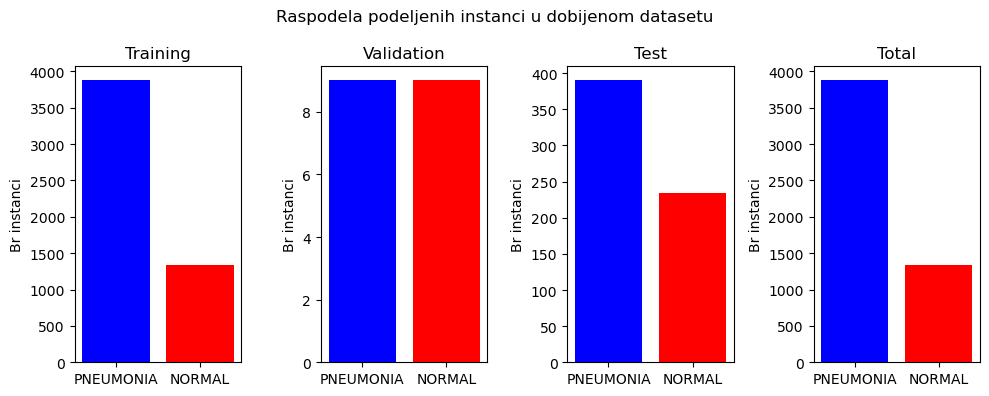

In [ ]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

broj_train = {}
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_train[subdir] = len(os.listdir(subdir_path))

broj_val = {}
for subdir in os.listdir(val_dir):
    subdir_path = os.path.join(val_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_val[subdir] = len(os.listdir(subdir_path))

broj_test = {}
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_test[subdir] = len(os.listdir(subdir_path))
        
total = broj_test.copy() | broj_val.copy() | broj_train.copy()
fig, axes = plt.subplots(1, 4, figsize= (10, 4))

axes[0].bar(broj_train.keys(), broj_train.values(), color=['blue', 'red'])
axes[0].set_ylabel('Br instanci')
axes[0].set_title('Training')

axes[1].bar(broj_val.keys(), broj_val.values(), color=['blue', 'red'])
axes[1].set_ylabel('Br instanci')
axes[1].set_title('Validation')

axes[2].bar(broj_test.keys(), broj_test.values(), color=['blue', 'red'])
axes[2].set_ylabel('Br instanci')
axes[2].set_title('Test')

axes[3].bar(total.keys(), total.values(), color=['blue', 'red'])
axes[3].set_ylabel('Br instanci')
axes[3].set_title('Total')

plt.suptitle('Raspodela podeljenih instanci u dobijenom datasetu')
plt.tight_layout()
plt.show()


Na osnovu dobijenog grafika se može zaključiti da je dataset nebalansiran, odnosno da sadrži značajno više instanci PNEUMONIA u odnosu na NORMAL. Takođe, nije jasna procentualna podela podataka ukupnog skupa na validation i test deo, te se u nastavku kreira novi dataset koji train:validation:test deli u odnosu 80:10:10 i prikazuje njihov odnos na bar chart-u. 

### Preprocesiranje podataka

#### Train, test, validation split

Ideja je da u narednom delu koda da slike posmatram kao špil karata. Sve da ih stavim na jedno mesto, promešam ih i izdelim u gore pomenutim proporcijama. 

In [ ]:
dataset_path= 'chest_xray/'
novi_dataset_path = 'chest_xray_new/'
if not os.path.exists(novi_dataset_path):
   for tip in ['train', 'val', 'test']:
       for kategorija in ['NORMAL', 'PNEUMONIA']:
           os.makedirs(f'{novi_dataset_path}/{tip}/{kategorija}', exist_ok=True)

   for kategorija in ['NORMAL', 'PNEUMONIA']:
       all_files = []
       for tip in ['train', 'val', 'test']:
           source_folder = f'{dataset_path}/{tip}/{kategorija}'
           files = os.listdir(source_folder)
           all_files.extend([(file, source_folder) for file in files])

       random.shuffle(all_files)
       #80:10:10 
       train_files = all_files[:int(len(all_files)*0.8)]
       val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
       test_files = all_files[int(len(all_files)*0.9):]

       for file, source_folder in train_files:
           dest = f'{novi_dataset_path}/train/{kategorija}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in val_files:
           dest = f'{novi_dataset_path}/val/{kategorija}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in test_files:
           dest = f'{novi_dataset_path}/test/{kategorija}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)  


In [ ]:
train_dir = 'chest_xray_new/train'
val_dir = 'chest_xray_new/val'
test_dir = 'chest_xray_new/test'

broj_train = {}
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_train[subdir] = len(os.listdir(subdir_path))

broj_val = {}
for subdir in os.listdir(val_dir):
    subdir_path = os.path.join(val_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_val[subdir] = len(os.listdir(subdir_path))

broj_test = {}
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_test[subdir] = len(os.listdir(subdir_path))
        
print ('Broj instanci za:')
print ('Pneumonia train: ', broj_train['PNEUMONIA'], '; Normal train: ', broj_train['NORMAL'])
print ('Pneumonia test i val: ', broj_test['PNEUMONIA'], '; Normal train i val: ', broj_test['NORMAL'])

Broj instanci za:
Pneumonia train:  3419 ; Normal train:  1267
Pneumonia test i val:  428 ; Normal train i val:  159


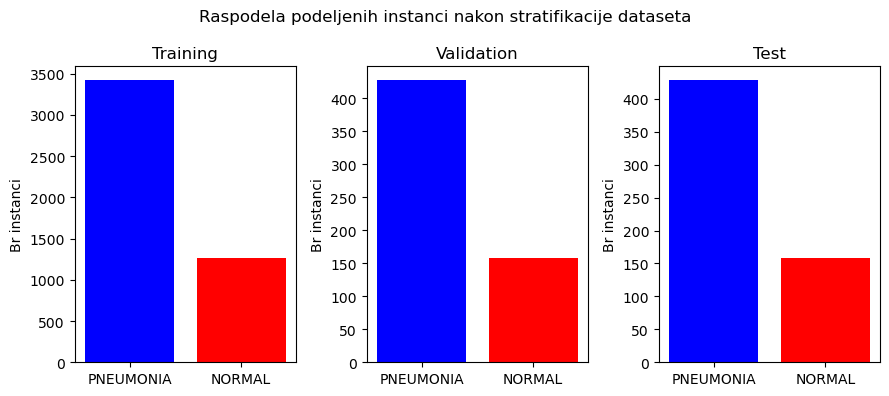

In [ ]:
fig, axes = plt.subplots(1, 3, figsize= (9, 4))

axes[0].bar(broj_train.keys(), broj_train.values(), color=['blue', 'red'])
axes[0].set_ylabel('Br instanci')
axes[0].set_title('Training')

axes[1].bar(broj_val.keys(), broj_val.values(), color=['blue', 'red'])
axes[1].set_ylabel('Br instanci')
axes[1].set_title('Validation')

axes[2].bar(broj_test.keys(), broj_test.values(), color=['blue', 'red'])
axes[2].set_ylabel('Br instanci')
axes[2].set_title('Test')

plt.suptitle('Raspodela podeljenih instanci nakon stratifikacije dataseta')
plt.tight_layout()
plt.show()

Sada smo skup stratifikovali, odnosno odnos svih klasa je jednak u svim datasetovima, možemo kreirati Keras Dataset objekte

#### Kreiranje Keras datasetova

Radi efikasnosti, rezoluciju slika ćemo podesiti da bude 240x240px, a za batchsize ćemo postaviti 32. 

In [ ]:
img_h = 240
img_w = 240
batch_size = 32

Obzirom na to da će u ovom delu biti korišćena Keras biblioteka, koristićemo bibliotečku podršku za definisanje datasetova. 

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    color_mode = 'grayscale',
    image_size = (img_h, img_w),
    batch_size = batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, 
    color_mode = 'grayscale',
    image_size = (img_h, img_w),
    batch_size = batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    color_mode = 'grayscale',
    image_size = (img_h, img_w),
    batch_size = batch_size)

Found 4684 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 587 files belonging to 2 classes.


2024-09-30 21:01:06.081819: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-30 21:01:06.081847: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-30 21:01:06.081855: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-30 21:01:06.081869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-30 21:01:06.081880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 240, 240, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

#### Balansiranje skupova

Obzirom na to da klasa Pneumonija ima više instanci od Normal klase, izvršićemo i balansiranje skupa postavljanjem težina, koje ćemo kasnije iskoristiti. 

In [ ]:
train_labels = np.concatenate([labels.numpy() for _, labels in train_ds])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

2024-09-30 21:01:09.854047: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


U nastavku ćemo prikazati 9 nasumičnih primera fotografija rendgena grudnog koša iz dataseta, zajedno sa njihovim oznakama. 

2024-09-30 21:01:09.976262: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


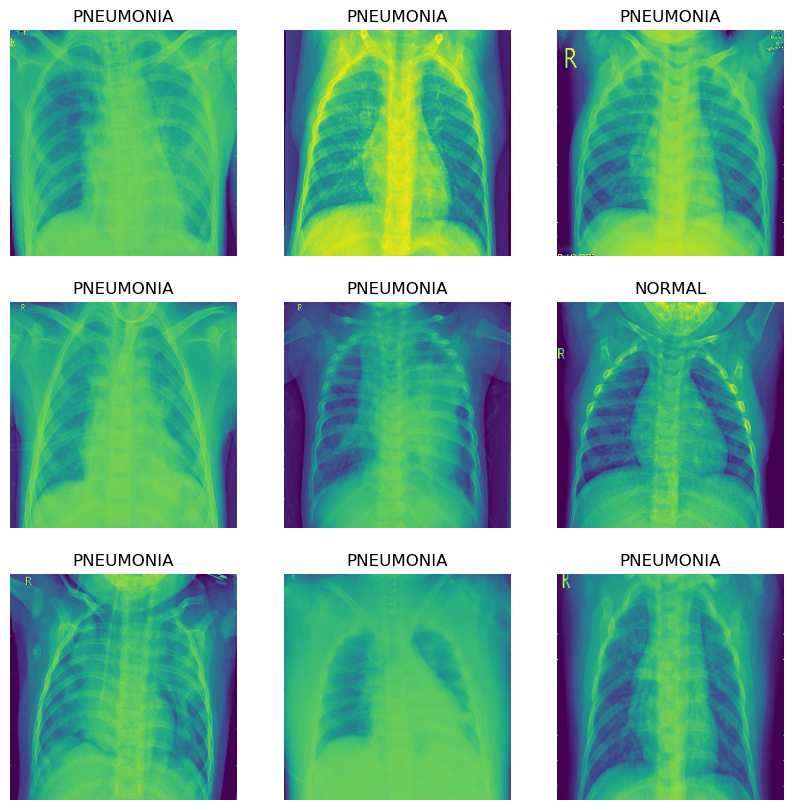

In [ ]:
plt.figure(figsize=(10, 10))
for slike, oznake in train_ds.take(1): 
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(slike[i].numpy().astype("uint8")))
        plt.title(train_ds.class_names[oznake[i]]) 
        plt.axis("off")                  

Radi optimizacije modela, koristićemo automatsku alokaciju dostupne lokalne memorije za optimalnije korišćenje dataseta u epohama. 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

Definisanje modela
---
- Na početku ćemo kreirati sloj koji normalizuje vrednost piksela, koji može imati vrednost od 0-255 (2^8), obzirom na to da je reč o crno-beloj slici, tako da vrednosti budu na skali od 0 do 1.
- Nakon toga postavljamo tri skrivena sloja koji koriste ReLU aktivacionu funkciju. Prvi ima 32 filtera veličine 3x3, naredni ima 64 i nakon njega 128 filtera. Nakon svakog konvolucionog sloja postavlja se i MaxPooling sloj koji smanjuje dimenziju izlaza prethodnog konvolucionog sloja za polovinu, koristeći maksimalnu vrednost u svakom regionu, odnosno u svakom 2x2 regionu što je default vrednost. 
- Nakon ovoga imamo kreiramo dva potpuno povezana sloja, koje prethodno izravnjujemo sa Flatten slojem, koristeći sa ReLU aktivacionom funkciju i L2 regularizacijom, Dropout radi regularizacije i izlazni sloj sa sigmoidnom aktivacionom funkcijom. 

In [ ]:
model_weights = tf.keras.Sequential([
    
    layers.Rescaling(scale=1./255), 
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.25),

    layers.Dense(1, activation='sigmoid')
])    

Zatim model kompajliramo sa Adam optimajzerom, binarnom krosentropijom za funkciju gubitka i accuracy za metriku i fitujemo model. 

In [ ]:
model_weights.compile( optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'] )

### Treniranje modela

In [ ]:
history_model_weights = model_weights.fit(train_ds, 
                                          validation_data = val_ds, 
                                          epochs = 30, 
                                          verbose = 1, 
                                          class_weight = class_weights_dict )

Epoch 1/30


2024-09-30 21:01:10.936162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 203ms/step - accuracy: 0.5923 - loss: 2.6191 - val_accuracy: 0.7436 - val_loss: 0.9517
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.8738 - loss: 0.6122 - val_accuracy: 0.8872 - val_loss: 0.5317
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.8809 - loss: 0.5055 - val_accuracy: 0.9060 - val_loss: 0.4484
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.8977 - loss: 0.4351 - val_accuracy: 0.9094 - val_loss: 0.4480
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.8998 - loss: 0.4094 - val_accuracy: 0.9265 - val_loss: 0.3664
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.8948 - loss: 0.3948 - val_accuracy: 0.9094 - val_loss: 0.3992
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.8939 - loss: 0.3925 - val_accuracy: 0.9128 - val_loss: 0.3993
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.9090 - loss: 0.3487 - val

Izvlačimo i plotujemo loss i accuracy vrednosti po epohama.

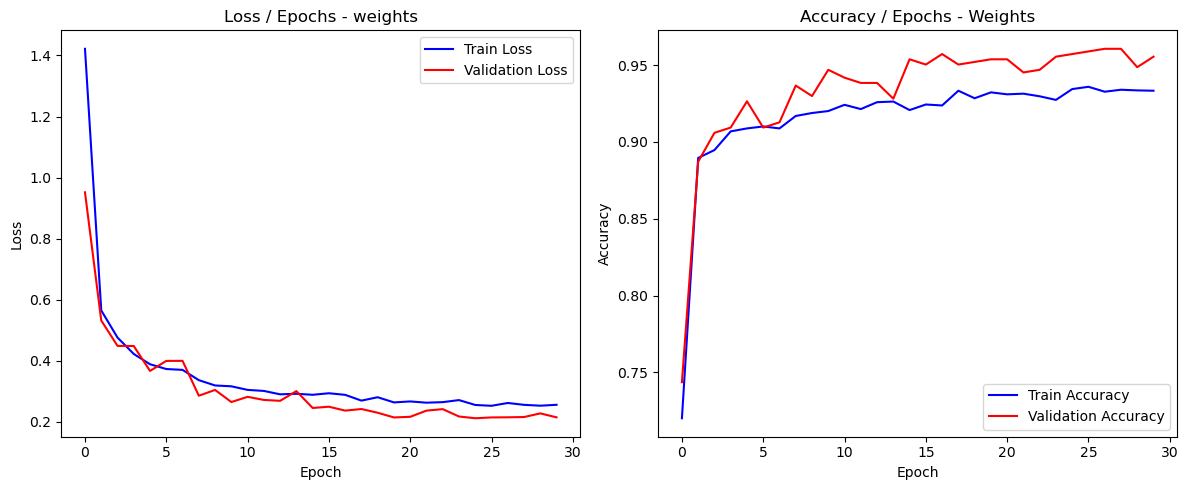

In [ ]:
train_loss_weights = model_weights.history.history['loss']
val_loss_weights = model_weights.history.history['val_loss']
train_accuracy_weights = model_weights.history.history['accuracy']
val_accuracy_weights = model_weights.history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_weights, label='Train Loss', color='blue')
plt.plot(val_loss_weights, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss / Epochs - weights')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_weights, label='Train Accuracy', color='blue')
plt.plot(val_accuracy_weights, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy / Epochs - Weights')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluacija

In [ ]:
model_weights.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9490 - loss: 0.2288


[0.24053798615932465, 0.9420783519744873]

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)


y_pred_model_weights = model_weights.predict(test_ds)
y_pred_model_weights = (y_pred_model_weights > 0.5).astype("int32")

print ('F1 modela sa tezinama: ', metrics.f1_score(y_true, y_pred_model_weights), 
       '\nPrecision modela sa tezinama: ', metrics.precision_score(y_true, y_pred_model_weights), 
       '\nRecall modela sa tezinama: ', metrics.recall_score(y_true, y_pred_model_weights, average=None), 
       '\nAccuracy modela sa tezinama: ', metrics.accuracy_score(y_true, y_pred_model_weights))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
F1 modela sa tezinama:  0.9602803738317757 
Precision modela sa tezinama:  0.9602803738317757 
Recall modela sa tezinama:  [0.89308176 0.96028037] 
Accuracy modela sa tezinama:  0.9420783645655877


In [ ]:
cm_model_weights = tf.math.confusion_matrix(y_true, y_pred_model_weights).numpy()
cm_model_weights

array([[142,  17],
       [ 17, 411]], dtype=int32)

Iscrtavanje confusion matrice za test dataset

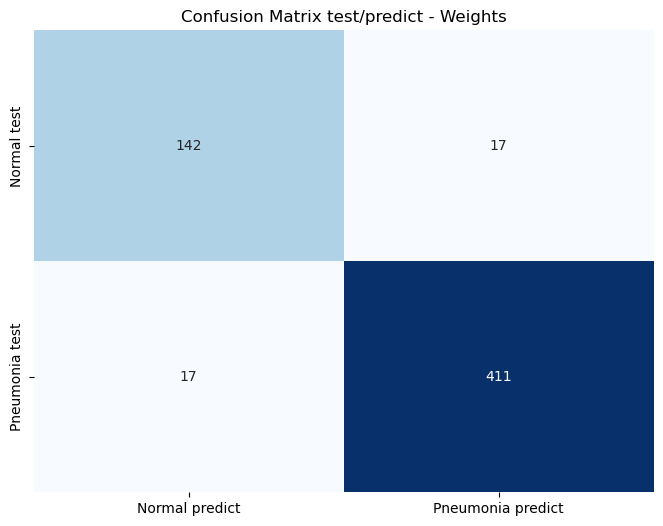

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_weights, annot=True, fmt='d', cmap = 'Blues', cbar=False, xticklabels=['Normal predict', 'Pneumonia predict'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix test/predict - Weights')
plt.show()

ROC AUC:  0.9266810674190326


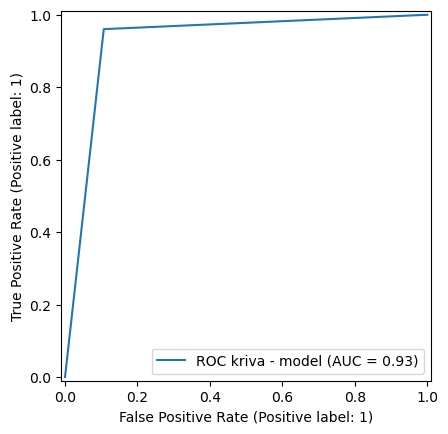

In [ ]:
metrics.RocCurveDisplay.from_predictions(y_true, y_pred_model_weights, name="ROC kriva - model")
print ('ROC AUC: ', metrics.roc_auc_score(y_true, y_pred_model_weights))

In [ ]:
cr_model_weights  = metrics.classification_report(y_true, y_pred_model_weights)
print(cr_model_weights)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       159
           1       0.96      0.96      0.96       428

    accuracy                           0.94       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.94      0.94      0.94       587



Sa presekom na 0.25

In [ ]:
y_pred_model_weights_025 = model_weights.predict(test_ds)
y_pred_model_weights_025 = (y_pred_model_weights_025 > 0.25).astype("int32")

print ('F1 modela sa tezinama 0225: ', metrics.f1_score(y_true, y_pred_model_weights_025), 
       '\nPrecision modela sa tezinama 025: ', metrics.precision_score(y_true, y_pred_model_weights_025), 
       '\nRecall modela sa tezinama 025: ', metrics.recall_score(y_true, y_pred_model_weights_025, average=None), 
       '\nAccuracy modela sa tezinama 025: ', metrics.accuracy_score(y_true, y_pred_model_weights_025))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
F1 modela sa tezinama 0225:  0.9575200918484501 
Precision modela sa tezinama 025:  0.9413092550790068 
Recall modela sa tezinama 025:  [0.83647799 0.97429907] 
Accuracy modela sa tezinama 025:  0.9369676320272572


In [ ]:
cm_model_weights_025 = tf.math.confusion_matrix(y_true, y_pred_model_weights_025).numpy()
cm_model_weights_025

array([[133,  26],
       [ 11, 417]], dtype=int32)

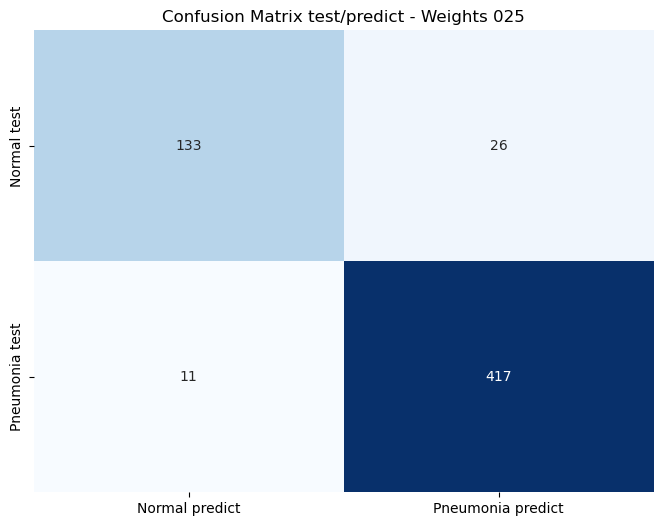

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_weights_025, annot=True, fmt='d', cmap = 'Blues', cbar=False, xticklabels=['Normal predict', 'Pneumonia predict'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix test/predict - Weights 025')
plt.show()

ROC AUC weights 025:  0.9053885264209722


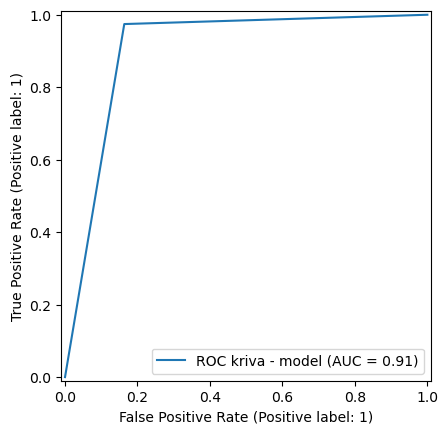

In [ ]:
metrics.RocCurveDisplay.from_predictions(y_true, y_pred_model_weights_025, name="ROC kriva - model")
print ('ROC AUC weights 025: ', metrics.roc_auc_score(y_true, y_pred_model_weights_025))

In [ ]:
cr_model_weights_025 = metrics.classification_report(y_true, y_pred_model_weights_025)
print(cr_model_weights_025)

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       159
           1       0.94      0.97      0.96       428

    accuracy                           0.94       587
   macro avg       0.93      0.91      0.92       587
weighted avg       0.94      0.94      0.94       587



---

## Drugi model, bez dodatih težina

Gledanjem konfuzione matrice, dolazim do zaključka da je model 17 instanci na test skupu kao da je reč o normalnom odnosno zdravom primeru rendgena grudnog koša, kada je zapravo reč o snimcima koji imaju upalu pluća. Naravno, ovaj broj želimo da smanjimo, tako da u drugom delu izbacujemo težine koje smo postavili, kako bismo stavili veći fokus na Pneumonija klasu. Sama postavka modela će biti identična kao i prethodni model. 

In [ ]:
model = tf.keras.Sequential([
    
    layers.Rescaling(scale=1./255), 
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.25),

    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile( optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'] )

In [ ]:
history_model = model.fit(train_ds, 
                          validation_data = val_ds, 
                          epochs = 30, 
                          verbose = 1 )

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.7268 - loss: 1.9780 - val_accuracy: 0.9265 - val_loss: 0.5295
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9014 - loss: 0.5230 - val_accuracy: 0.9350 - val_loss: 0.4078
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.9157 - loss: 0.3874 - val_accuracy: 0.9299 - val_loss: 0.3493
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.9210 - loss: 0.3335 - val_accuracy: 0.9197 - val_loss: 0.3276
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.9266 - loss: 0.3054 - val_accuracy: 0.9145 - val_loss: 0.3416
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.9204 - loss: 0.3130 - val_accuracy: 0.9368 - val_loss: 0.2874
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9231 - loss: 0.2892 - val_accuracy: 0.9231 - val_loss: 0.3093
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9282 - loss: 0

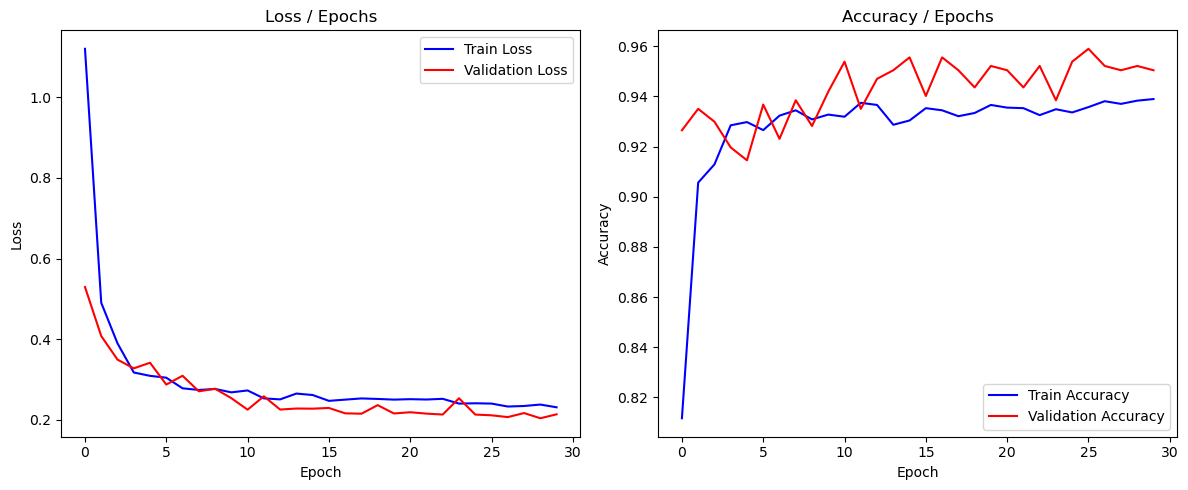

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss / Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy / Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#### Evaluacija


In [ ]:
model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9443 - loss: 0.2201


[0.23545317351818085, 0.9420783519744873]

In [ ]:
y_pred_model = model.predict(test_ds)
y_pred_model = (y_pred_model > 0.5).astype("int32")


print ('F1 model bez tezina: ', metrics.f1_score(y_true, y_pred_model), 
       '\nPrecision model bez tezina: ', metrics.precision_score(y_true, y_pred_model), 
       '\nRecall model bez tezina: ', metrics.recall_score(y_true, y_pred_model, average=None), 
       '\nAccuracy model bez tezina: ', metrics.accuracy_score(y_true, y_pred_model))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
F1 model bez tezina:  0.96 
Precision model bez tezina:  0.966824644549763 
Recall model bez tezina:  [0.91194969 0.95327103] 
Accuracy model bez tezina:  0.9420783645655877


In [ ]:
cm_model = tf.math.confusion_matrix(y_true, y_pred_model).numpy()
cm_model

array([[145,  14],
       [ 20, 408]], dtype=int32)

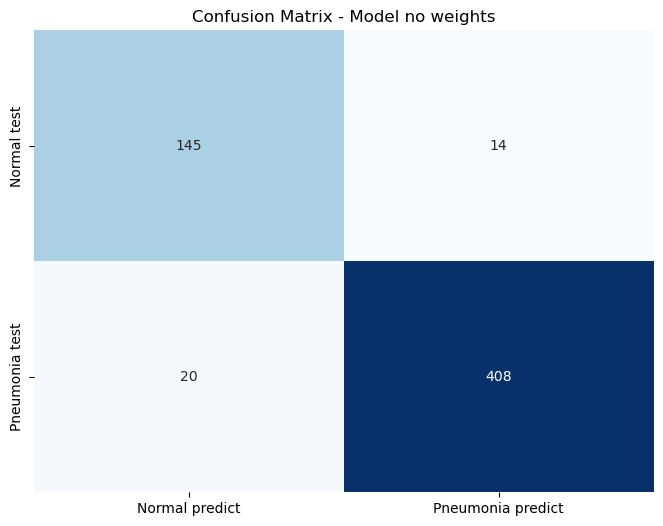

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model, annot=True, fmt='d', cmap = 'Blues', cbar=False, xticklabels=['Normal predict', 'Pneumonia predict'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix - Model no weights')
plt.show()

ROC AUC:  0.9326103567859871


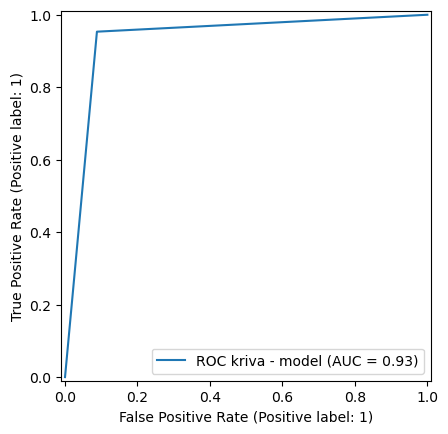

In [ ]:
metrics.RocCurveDisplay.from_predictions(y_true, y_pred_model, name="ROC kriva - model", )
print ('ROC AUC: ', metrics.roc_auc_score(y_true, y_pred_model))

In [ ]:
cr_model = metrics.classification_report(y_true, y_pred_model)
print(cr_model)

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       159
           1       0.97      0.95      0.96       428

    accuracy                           0.94       587
   macro avg       0.92      0.93      0.93       587
weighted avg       0.94      0.94      0.94       587



Sa presekom na 025

In [ ]:
y_pred_model_025 = model.predict(test_ds)
y_pred_model_025 = (y_pred_model_025 > 0.25).astype("int32")

print ('F1 model bez tezina 025: ', metrics.f1_score(y_true, y_pred_model_025), 
       '\nPrecision model bez tezina 025: ', metrics.precision_score(y_true, y_pred_model_025), 
       '\nRecall model bez tezina 025: ', metrics.recall_score(y_true, y_pred_model_025, average=None), 
       '\nAccuracy model bez tezina 025: ', metrics.accuracy_score(y_true, y_pred_model_025))



19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
F1 model bez tezina 025:  0.9608294930875576 
Precision model bez tezina 025:  0.9477272727272728 
Recall model bez tezina 025:  [0.85534591 0.97429907] 
Accuracy model bez tezina 025:  0.9420783645655877


In [ ]:
cm_model_025 = tf.math.confusion_matrix(y_true, y_pred_model_025).numpy()
cm_model_025

array([[136,  23],
       [ 11, 417]], dtype=int32)

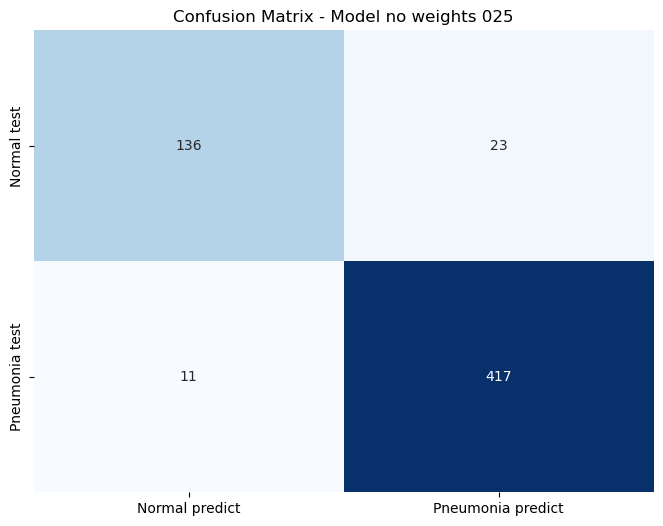

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_025, annot=True, fmt='d', cmap = 'Blues', cbar=False, xticklabels=['Normal predict', 'Pneumonia predict'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix - Model no weights 025')
plt.show()

ROC AUC:  0.9148224886851233


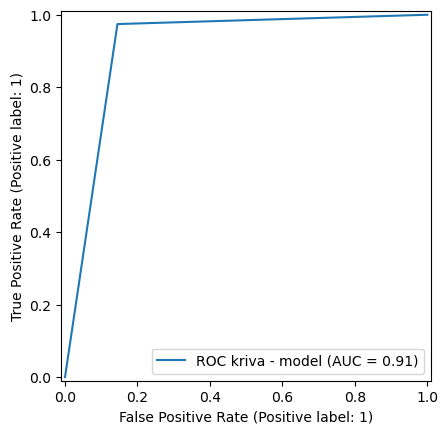

In [ ]:
metrics.RocCurveDisplay.from_predictions(y_true, y_pred_model_025, name="ROC kriva - model", )
print ('ROC AUC: ', metrics.roc_auc_score(y_true, y_pred_model_025))

In [ ]:
cr_model_025 = metrics.classification_report(y_true, y_pred_model_025)
print(cr_model_025)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       159
           1       0.95      0.97      0.96       428

    accuracy                           0.94       587
   macro avg       0.94      0.91      0.92       587
weighted avg       0.94      0.94      0.94       587



---

## Korišćenje pretreniranog VGG16 modela 

Sada možemo koristiti i jedan od pretreniranih modela i uporediti ga sa modelom koji je prethodno napravljen i treniran na istom datasetu. Probaćemo VGG16 model. Obzirom na to da ovaj model koristi RGB slike, a ulazni dataset je sa crno-belim slikama, potrebno je konvertovati ih tako što se isti kanal kopira tri puta (za r, g, b kanal i takve fotografije proslediti modelu)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
input_shape = (240, 240, 3)
def preprocess_image(image):
    return tf.image.grayscale_to_rgb(image)

In [ ]:
train_ds_rgb = train_ds.map(lambda x, y: (preprocess_image(x), y))
val_ds_rgb = val_ds.map(lambda x, y: (preprocess_image(x), y))
test_ds_rgb = test_ds.map(lambda x, y: (preprocess_image(x), y))

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=(img_h, img_w, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_vgg16 = Model(inputs, outputs)

In [ ]:
model_vgg16.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
history_vgg16 = model_vgg16.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=15,
    verbose=1
)

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 798ms/step - accuracy: 0.8912 - loss: 7.6232 - val_accuracy: 0.9573 - val_loss: 1.9229
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 803ms/step - accuracy: 0.9443 - loss: 1.7576 - val_accuracy: 0.9641 - val_loss: 1.2270
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 120s 820ms/step - accuracy: 0.9511 - loss: 1.1437 - val_accuracy: 0.9350 - val_loss: 1.0007
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 807ms/step - accuracy: 0.9475 - loss: 0.9069 - val_accuracy: 0.9675 - val_loss: 0.7177
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 132s 898ms/step - accuracy: 0.9366 - loss: 0.7942 - val_accuracy: 0.9607 - val_loss: 0.6488
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 129s 876ms/step - accuracy: 0.9374 - loss: 0.6534 - val_accuracy: 0.9692 - val_loss: 0.5455
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 938ms/step - accuracy: 0.9365 - loss: 0.5822 - val_accuracy: 0.9675 - val_loss: 0.4691
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 941ms/step - accuracy: 0.9257 -

#### Evaluacija pretreniranog modela

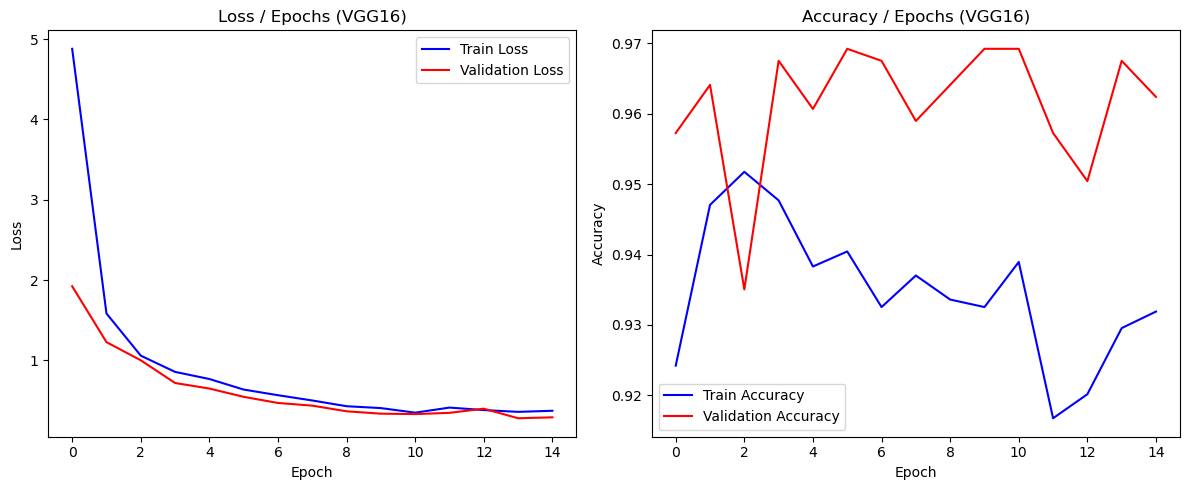

In [ ]:
train_loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']
train_accuracy_vgg16 = history_vgg16.history['accuracy']
val_accuracy_vgg16 = history_vgg16.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_vgg16, label='Train Loss', color='blue')
plt.plot(val_loss_vgg16, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss / Epochs (VGG16)')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_vgg16, label='Train Accuracy', color='blue')
plt.plot(val_accuracy_vgg16, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy / Epochs (VGG16)')
plt.legend()

plt.tight_layout()
plt.show()

Evaluacija VGG16 modela

19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9688 - loss: 0.2679
Test Loss (VGG16): 0.28512832522392273
Test Accuracy (VGG16): 0.9625213146209717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


2024-09-30 22:04:13.964868: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


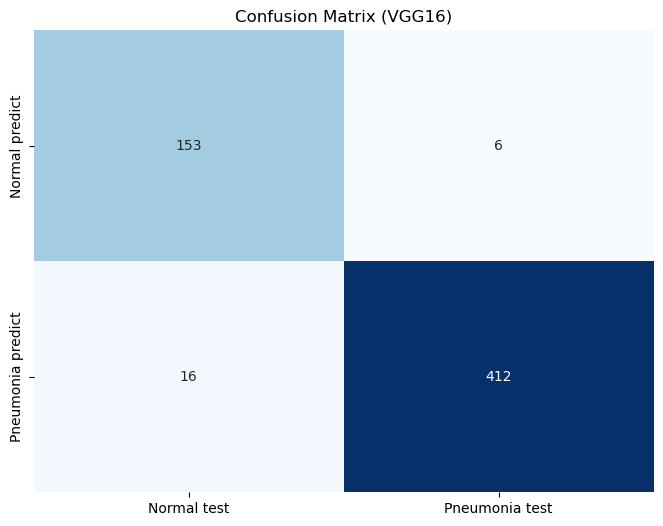

In [ ]:
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_ds_rgb)

print(f'Test Loss (VGG16): {test_loss_vgg16}')
print(f'Test Accuracy (VGG16): {test_accuracy_vgg16}')

y_true_vgg16 = []
y_pred_vgg16 = []

for images, labels in test_ds_rgb:
    y_true_vgg16.extend(labels.numpy())
    predictions = model_vgg16.predict(images)
    y_pred_vgg16.extend(np.round(predictions).flatten())

y_true_vgg16 = np.array(y_true_vgg16)
y_pred_vgg16 = np.array(y_pred_vgg16)

cm_vgg16 = tf.math.confusion_matrix(y_true_vgg16, y_pred_vgg16).numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal test', 'Pneumonia test'], yticklabels=['Normal predict', 'Pneumonia predict'])
plt.title('Confusion Matrix (VGG16)')
plt.show()

In [ ]:
y_pred_vgg16 = model_vgg16.predict(test_ds_rgb)
y_pred_vgg16 = (y_pred_vgg16 > 0.5).astype("int32")
y_true_vgg16 = np.concatenate([y for x, y in test_ds_rgb], axis=0)

print ('F1 VGG16: ', metrics.f1_score(y_true_vgg16, y_pred_vgg16), 
       '\nPrecision VGG16: ', metrics.precision_score(y_true_vgg16, y_pred_vgg16, average=None), 
       '\nRecall VGG16: ', metrics.recall_score(y_true_vgg16, y_pred_vgg16), 
       '\nAccuracy VGG16: ', metrics.accuracy_score(y_true_vgg16, y_pred_vgg16))

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
F1 VGG16:  0.9739952718676123 
Precision VGG16:  [0.90532544 0.98564593] 
Recall VGG16:  0.9626168224299065 
Accuracy VGG16:  0.9625212947189097


In [ ]:
cr_vgg16 = metrics.classification_report(y_true_vgg16, y_pred_vgg16)
print (cr_vgg16)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       159
           1       0.99      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.95      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



In [ ]:
y_pred_vgg16_025 = model_vgg16.predict(test_ds_rgb)
y_pred_vgg16_025 = (y_pred_vgg16 > 0.25).astype("int32")

print ('F1 VGG16: ', metrics.f1_score(y_true_vgg16, y_pred_vgg16_025), 
       '\nPrecision VGG16: ', metrics.precision_score(y_true_vgg16, y_pred_vgg16_025, average=None), 
       '\nRecall VGG16: ', metrics.recall_score(y_true_vgg16, y_pred_vgg16_025), 
       '\nAccuracy VGG16: ', metrics.accuracy_score(y_true_vgg16, y_pred_vgg16_025))

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 731ms/step
F1 VGG16:  0.9739952718676123 
Precision VGG16:  [0.90532544 0.98564593] 
Recall VGG16:  0.9626168224299065 
Accuracy VGG16:  0.9625212947189097


In [ ]:
cr_vgg16 = metrics.classification_report(y_true_vgg16, y_pred_vgg16)
print (cr_vgg16)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       159
           1       0.99      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.95      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



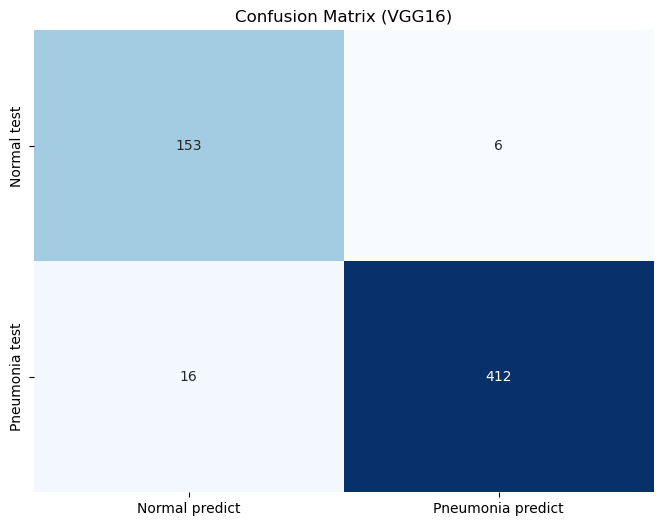

In [ ]:
cm_vgg16_025 = tf.math.confusion_matrix(y_true_vgg16, y_pred_vgg16_025).numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg16_025, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal predict', 'Pneumonia predict'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix (VGG16)')
plt.show()

ROC AUC:  0.9624404866866514


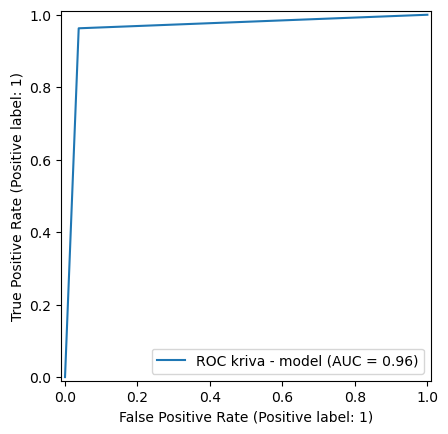

In [ ]:
metrics.RocCurveDisplay.from_predictions(y_true, y_pred_vgg16, name="ROC kriva - model", )
print ('ROC AUC: ', metrics.roc_auc_score(y_true, y_pred_vgg16))